# Milestone 2

In [ ]:
# Install missing packages
%pip install cpi

In [1]:
#we import all the necessary librairies here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import ast
import cpi
import plotly.express as px
import plotly.graph_objects as go

# Make sure that we have the good rate for computing the inflation
cpi.update()


In [2]:
#data paths
data_path = './data/'
cmu_path = data_path+'MovieSummaries/'
acl_persona_path = data_path+'ACL_personas_dump/personas/'

In [119]:
# color for data visualisation

# Single color graph
SING_COLOR = 'skyblue'
# Multi color graph
MULT_COLOR = px.colors.qualitative.T10
# Template for graph
TEMPLATE = 'seaborn'

## 1. Data cleaning and preprocessing

In this part we will import, clean and transform the data we will use for later analysis.

- We will first create a more complete movie dataset by merging the data from cmu with some useful data from imdb.
- Then, the dataset is cleaned and transformed to be used for later analysis.
- We perform the same cleaning for the character dataset.
- Once all the datasets are ready, we compute a fame score to quantisize the sucess of an actor. This a first version of the fame score that we will show as satisfying enough for the pre-analysis. It will be improved based on futur milestone with more complex computations.
- Finally, we load the dataset from ACL_personas_dump and merge it with the character one to get associate personas to each character.   

#### 1.1 Movie dataset

Let's first have a look at the cmu movie dataset more in details to see what we can do with it.

In [3]:
#Import the cmu movie dataset and print a sample of 5 random row in the dataset
cmu_movie_cols = ['wikiID',
                  'freebase_movID',
                  'movie_name',
                  'release_date',
                  'boxoffice',
                  'runtime',
                  'language',
                  'country',
                  'genre']

cmu_movies = pd.read_csv(data_path+'movie.metadata.tsv', sep='\t', names=cmu_movie_cols)
cmu_movies.sample(5)

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre
24458,9993305,/m/06_ybbb,Breve cielo,1969,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/07s9rl0"": ""Drama""}"
3854,2082089,/m/06kyc4,Trixie,2000,295683.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th..."
43214,20953049,/m/05b1h77,Photographing a Ghost,1898,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film""}"
43420,21425901,/m/05f7qdl,Sacrifices of the Heart,NaN,NaN,NaN,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
50948,22028230,/m/05pb6f2,Leprechaun,1993,NaN,NaN,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/03npn"": ""Horror"", ""/m/01z4y"": ""Comedy""}"


In [4]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikiID          81741 non-null  int64  
 1   freebase_movID  81741 non-null  object 
 2   movie_name      81741 non-null  object 
 3   release_date    74839 non-null  object 
 4   boxoffice       8401 non-null   float64
 5   runtime         61291 non-null  float64
 6   language        81741 non-null  object 
 7   country         81741 non-null  object 
 8   genre           81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


The first thing we see here is that we do not have a lot of boxoffice data for the movies. However we need a way to asses the success of a movie for our analysis (we will later use this notion to compute a fame score for the actors).

To solve this issue we decided that we will use the imdb rating and number of votes as a proxy for the success and popularity of a movie.

In [5]:
# As the dataset is pretty big, we won't bother importing columns that we don't need later to save memory space
col_to_load = ['tconst','primaryTitle','startYear']
col_dtype = {'tconst': str, 'primaryTitle': str, 'startYear': 'Int64'}

imdb_movies = pd.read_csv(data_path+'title_basics.tsv', usecols=col_to_load, sep='\t', na_values=['\\N'], 
                          dtype=col_dtype)
imdb_ratings= pd.read_csv(data_path+'title_ratings.tsv', sep='\t')

# As this dataset is a way for us to get the title of the rating dataset, we will drop all 
# the rows that have NaN values in the primaryTitle column.
imdb_movies.dropna(subset=['primaryTitle'], inplace=True)


Now let's combine the two to have a new dataset containing the title of the movie and its rating.

In [7]:
imdb_movies_ratings = imdb_movies.merge(imdb_ratings,how='inner',on='tconst')
imdb_movies_ratings.sample(5)

,tconst,primaryTitle,startYear,averageRating,numVotes
664032,tt14068844,Muerte Del Alma,2022,9.0,26
173465,tt0287935,Blind,1999,6.8,14
650544,tt1378686,Homoworld,2010,5.6,10
486977,tt10603640,Episode #1.19,2003,8.7,7
113697,tt0165589,No That's Me Over Here,1967,7.4,25


Now that we have a dataset with the title of the movie and its rating, we can clean the duplicates and the movies with no rating.

In [8]:
imdb_movies_ratings.primaryTitle = imdb_movies_ratings.primaryTitle.str.lower()
imdb_movies_ratings.drop_duplicates(subset=['primaryTitle','startYear'],inplace=True)
imdb_movies_ratings.dropna(subset=['averageRating'], inplace=True)

Now let's merge it to the cmu dataset in order to have a dataset with all the information we need.

In [9]:
#first we lower the title also in the cmu dataset
cmu_movies.movie_name = cmu_movies.movie_name.str.lower()

#then we retrieve the release year of the movies in the cmu dataset
cmu_movies['release_year'] = pd.to_numeric(cmu_movies.release_date.astype(str).str[:4], errors='coerce') \
                               .astype('Int64')
cmu_movies.dropna(subset=['release_year'], inplace=True)

cmu_imdb_movies = cmu_movies.merge(imdb_movies_ratings,left_on=['movie_name','release_year'],
                                                       right_on=['primaryTitle','startYear'])
cmu_movies = cmu_imdb_movies.drop(columns=['tconst','primaryTitle','startYear','release_year']).copy()
cmu_movies.sample(5)

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre,averageRating,numVotes
38098,24089925,/m/07kcf7v,transylmania,2009-12-04,NaN,97.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/0gf28"": ""Parody"", ""/m/03npn"": ""Horror"", ""...",3.8,2838
31643,2823848,/m/084_x6,something like happiness,2005,NaN,100.0,"{""/m/01wgr"": ""Czech Language""}","{""/m/01mjq"": ""Czech Republic"", ""/m/0345h"": ""Ge...","{""/m/03q4nz"": ""World cinema"", ""/m/0clz1b"": ""Sl...",7.1,1540
15693,5861532,/m/0f9l5n,paradise alley,1978,7185518.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01z02hx"": ""Sports"", ""/m/04xvlr"": ""Period ...",5.7,5804
16412,30994358,/m/0gg9z1z,o-kay for sound,1937,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01z4y"": ""Comedy""}",5.9,104
49165,4565097,/m/0c94b6,succubus,2006-03,NaN,93.0,"{""/m/01gp_d"": ""Finnish Language""}","{""/m/02vzc"": ""Finland""}","{""/m/03npn"": ""Horror"", ""/m/0219x_"": ""Indie"", ""...",5.4,38


Now that we have all the information we need, we can start working on making the dataset more usable for our analysis.

In [10]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49991 entries, 0 to 49990
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikiID          49991 non-null  int64  
 1   freebase_movID  49991 non-null  object 
 2   movie_name      49991 non-null  object 
 3   release_date    49991 non-null  object 
 4   boxoffice       7462 non-null   float64
 5   runtime         41921 non-null  float64
 6   language        49991 non-null  object 
 7   country         49991 non-null  object 
 8   genre           49991 non-null  object 
 9   averageRating   49991 non-null  float64
 10  numVotes        49991 non-null  int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 4.2+ MB


As we can see here the date are not in a very usable format. We will need to convert them to a datetime format.

In [11]:
cmu_movies['release_date'] = cmu_movies['release_date'].apply(pd.to_datetime)

#we check if we have coherent date
cmu_movies.release_date.describe()

count                            49991
mean     1979-02-19 06:39:42.044768128
min                1888-01-01 00:00:00
25%                1957-02-13 12:00:00
50%                1987-01-01 00:00:00
75%                2003-10-24 00:00:00
max                2016-03-18 00:00:00
Name: release_date, dtype: object

We will now check the distribution of the movies we have through the years. and we will drop the years that have too few movies.

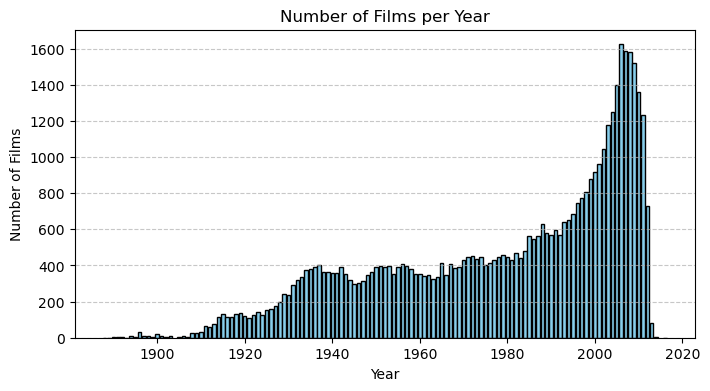

In [12]:
grouped_year = cmu_movies.groupby(cmu_movies.release_date.dt.year).agg(number_films=('movie_name','count')) \
                         .reset_index()

plt.figure(figsize=(8, 4))
plt.bar(grouped_year['release_date'], grouped_year['number_films'], color='skyblue', edgecolor='black')
plt.title('Number of Films per Year')
plt.xlabel('Year')
plt.ylabel('Number of Films')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [126]:
# Assuming you have a DataFrame named 'grouped_year' with columns 'release_date' and 'number_films'
fig = px.bar(grouped_year, x='release_date', y='number_films',
             labels={'number_films': 'Number of Films'},
             title='Number of Films per Year',
             template=TEMPLATE,  
             color_discrete_sequence=[SING_COLOR],  # Color of the bars
             height=500, width=1000)
fig.update_layout(xaxis_title='Year', yaxis_title='Number of Films', showlegend=False)

# Adding grid
fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgrey', zeroline=False)
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgrey', zeroline=False)

fig.show()


It seems the number of movies per year increases with years. Let's see a bit more in details how many years have less than 100, 500, 1000 movies.

In [15]:
# Print the years with less than 100, 500, and 1000 films
years_less_than_100 = grouped_year[grouped_year['number_films'] < 100]['release_date']
years_less_than_500 = grouped_year[grouped_year['number_films'] < 500]['release_date']
years_less_than_1000 = grouped_year[grouped_year['number_films'] < 1000]['release_date']

print(f'Number of years with less than 100 films: {len(years_less_than_100)}')
print(f'Number of years with less than 500 films: {len(years_less_than_500)}')
print(f'Number of years with less than 1000 films: {len(years_less_than_1000)}')

# Print the year with the max number of movies
max_films_year = grouped_year.loc[grouped_year['number_films'].idxmax(), 'release_date']
max_films_count = grouped_year['number_films'].max()
print(f'The year with the max number of films is: {max_films_year:.0f} with {max_films_count} films')

Number of years with less than 100 films: 28
Number of years with less than 500 films: 99
Number of years with less than 1000 films: 117
The year with the max number of films is: 2006 with 1624 films


We see that there are not that much years with less than 100 movies. We will drop them from our dataset, in order to have more significant results when we will do year based analysis.

In [16]:
# In the original CMU dataset remove the rows with release year with less than 100 films
years_to_remove = grouped_year[grouped_year['number_films'] < 100]['release_date'].tolist()
cmu_movies = cmu_movies[~cmu_movies.release_date.dt.year.isin(years_to_remove)].copy()

We have also the problem that so far the values in the columns 'language', 'country' and 'genre' are still in a object format and not easily usable. We will need to convert them to a more usable format. For an easy access to those values later we will interpret them as dictionaries that we'll convert to a list format since we do not need the keys (that come from freebase).

In [17]:
# Transform the object dtype into list of values:
# We use ast.literal_eval to interpret the string as a dictionnaries, we take only their values and 
# we convert it to a list
cmu_movies['language'] = cmu_movies['language'].apply(lambda x: list(ast.literal_eval(x).values())) 
cmu_movies['country'] = cmu_movies['country'].apply(lambda x: list(ast.literal_eval(x).values()))
cmu_movies['genre'] = cmu_movies['genre'].apply(lambda x: list(ast.literal_eval(x).values()))

# Check the max number of values in each list(i.e. the max number of languages, countries and genres for a movie)
print(f'The max number of values in a single list for language is {cmu_movies["language"].apply(len).max()}')
print(f'The max number of values in a single list for country is {cmu_movies["country"].apply(len).max()}')
print(f'The max number of values in a single list for genre is {cmu_movies["genre"].apply(len).max()}')

The max number of values in a single list for language is 11
The max number of values in a single list for country is 14
The max number of values in a single list for genre is 17


In [18]:
# Cleaned version of the CMU dataset
cmu_movies

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre,averageRating,numVotes
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",4.9,56928
1,28463795,/m/0crgdbh,brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",5.6,41
2,9363483,/m/0285_cd,white of the eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",6.1,2895
3,261236,/m/01mrr1,a woman in flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama],5.9,623
5,10408933,/m/02qc0j7,alexander's ragtime band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",6.8,2268
...,...,...,...,...,...,...,...,...,...,...,...
49986,15394941,/m/03m6zh4,gopi kishan,1994-12-02,NaN,NaN,[Hindi Language],[India],"[Drama, Action, Crime, Comedy]",5.8,964
49987,23851782,/m/06_vb43,the ghost train,1941-05-03,NaN,82.0,[English Language],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",6.2,1582
49988,35228177,/m/0j7hxnt,mermaids: the body found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],4.6,1711
49989,34980460,/m/0g4pl34,knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",6.8,3194


In [19]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49473 entries, 0 to 49990
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   wikiID          49473 non-null  int64         
 1   freebase_movID  49473 non-null  object        
 2   movie_name      49473 non-null  object        
 3   release_date    49473 non-null  datetime64[ns]
 4   boxoffice       7461 non-null   float64       
 5   runtime         41686 non-null  float64       
 6   language        49473 non-null  object        
 7   country         49473 non-null  object        
 8   genre           49473 non-null  object        
 9   averageRating   49473 non-null  float64       
 10  numVotes        49473 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 4.5+ MB


We see here that we have enough data for our analysis.

#### 1.2 Characters dataset

Now that we have a usable and clean dataset for the movies we will interest ourselves in the character dataset. To do that let first have a look at the dataset.

In [20]:
cmu_character_cols = ['wikiID',
                      'freebase_movID',
                      'release_date',
                      'character_name',
                      'actor_birth',
                      'actor_gender',
                      'actor_height',
                      'actor_ethnicity',
                      'actor_name',
                      'actor_age_at_release',
                      'freebase_char_actor_map',
                      'freebase_charID',
                      'freebase_actorID']

cmu_character = pd.read_table(data_path+'character.metadata.tsv', names=cmu_character_cols)
cmu_character.sample(5)

,wikiID,freebase_movID,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID
220014,781946,/m/03bxwl,1996-05-18,Dr. Richardson,1958-03-27,M,NaN,/m/02w7gg,Adrian Rawlins,38.0,/m/0c1lpcz,/m/0c1lpd1,/m/071nq3
72269,31761249,/m/0crsftt,1999,NaN,NaN,F,NaN,NaN,Crystal Bublé,NaN,/m/0gczy2f,NaN,/m/0gcy_j7
96801,26489416,/m/0bhbvj_,NaN,NaN,1926-04-21,F,1.63,NaN,Elizabeth II of the United Kingdom,NaN,/m/0h7v490,NaN,/m/0d1_f
397374,5667757,/m/0dz3s9,1960,NaN,1922-04-09,M,NaN,NaN,Arthur Batanides,37.0,/m/0dk0bpk,NaN,/m/02wz1xp
413259,5080406,/m/0d1tgy,2005-05-13,NaN,1953-10-11,M,1.93,NaN,David Morse,51.0,/m/0jxhm1,NaN,/m/06bzwt


In [21]:
cmu_character.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   wikiID                   450669 non-null  int64  
 1   freebase_movID           450669 non-null  object 
 2   release_date             440674 non-null  object 
 3   character_name           192794 non-null  object 
 4   actor_birth              344524 non-null  object 
 5   actor_gender             405060 non-null  object 
 6   actor_height             154824 non-null  float64
 7   actor_ethnicity          106058 non-null  object 
 8   actor_name               449441 non-null  object 
 9   actor_age_at_release     292556 non-null  float64
 10  freebase_char_actor_map  450669 non-null  object 
 11  freebase_charID          192804 non-null  object 
 12  freebase_actorID         449854 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 44.7+ MB


We will first drop any null value we have on the wikiID column or in the freebase_actorID column since we don't want character without actor or movie, we also drop the dupplicates if we have more than one character for the same actor in the same movie.

In [22]:
cmu_character.dropna(subset=['wikiID','freebase_actorID'], inplace=True)
cmu_character.drop_duplicates(subset=['wikiID','freebase_actorID'], inplace=True)

We will now create a dataset containing the information about the actors and the movies they played in.

In [23]:
actor_movie = cmu_character.drop(columns='release_date', axis=1) \
                           .merge(cmu_movies[['wikiID','averageRating','numVotes','release_date']],
                                  on='wikiID',how='inner')
actor_movie.sample(5)

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,averageRating,numVotes,release_date
14414,13166374,/m/02z9jqn,NaN,1921-12-05,M,NaN,NaN,Alvy Moore,61.0,/m/09j0dfr,NaN,/m/02z11_,5.0,30,1983-09-09
187465,1620886,/m/05h9zt,NaN,1954-05-08,M,1.83,NaN,David Keith,48.0,/m/02tb177,NaN,/m/036496,3.1,1065,2003-01-01
116868,4446720,/m/0c2xrs,Ben Reed,1949-12-15,M,1.80,NaN,Don Johnson,41.0,/m/02vc884,/m/0h281zs,/m/01mt1fy,6.6,3077,1991-01-01
189415,23789267,/m/04j04mh,NaN,1991-03-09,F,NaN,NaN,Brenna O'Brien,16.0,/m/0cs4j6x,NaN,/m/0by5zt,5.7,755,2008-01-01
131407,17240314,/m/043rbpp,Le propriétaire du vignoble,1962-02-07,M,NaN,NaN,Marc Rioufol,44.0,/m/0cg5klm,/m/0ghvw6h,/m/07xybsf,7.1,2560,2007-01-01


We will now compute a fame score for each actor basing ourselves on the three previous movies he played in to have for every actor a first carreer success indicator. This is subject to change but for the 2nd milestone this first version of the fame score is satisfying (we will show this later on).

We first define a function to compute this fame score and then we apply it to our dataset. 

The function follows this reasoning:
- A fame score should be high if a movie as a high rating and a high number of votes (we limit the impact of the number of votes by taking its log value). 
- The impact of previous movies should be mitigated by the time since the movie was released.

We will detail in the second part of this milestone why this fame score is satisfying for the pre-analysis.

In [24]:
def fame_score(row,data):
    ''' 
    This function computes the fame score of an actor based on the average rating and the number of votes of the 
    3 past movies, if they exist.
    '''

    n = row['index']
    rowm1 = data.iloc[n-1]
    rowm2 = data.iloc[n-2]

    actor = row['freebase_actorID']
    year = row['release_date'].year
    rate = row['averageRating']
    votes = row['numVotes']

    fame_score = rate * np.log(votes) / (year-1700)

    if rowm2['freebase_actorID'] == actor:
        year = rowm2['release_date'].year
        rate = rowm2['averageRating'] 
        votes = rowm2['numVotes']
        fame_score += rate * np.log(votes) / (year-1700)

    if rowm1['freebase_actorID'] == actor:
        year = rowm1['release_date'].year
        rate = rowm1['averageRating']
        votes = rowm1['numVotes']
        fame_score += rate * np.log(votes) / (year-1700)

    return fame_score

In [25]:
# For our function to work we need to have a sorted dataset
actor_movie.sort_values(by=['freebase_actorID','release_date'], inplace=True)
actor_movie.reset_index(drop=True,inplace=True)
actor_movie.reset_index(inplace=True)

In [26]:
# Apply the function to each row
actor_movie['fameScore'] = actor_movie.apply(lambda x: fame_score(x,actor_movie), axis=1)
actor_movie.drop('index',inplace=True,axis=1)

# We drop the columns we don't need anymore
cmu_character = actor_movie.drop(columns=['averageRating','numVotes']).copy()
cmu_character.sample(5)

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,release_date,fameScore
158813,627935,/m/02y8kn,NaN,1885-03-01,M,NaN,NaN,Lionel Atwill,NaN,/m/0k0g81,NaN,/m/06ljy0,1935-04-26,0.785418
210835,21282769,/m/05f4_n0,Sergeant Marcus Williams,1974-01-09,M,1.79,NaN,Omari Hardwick,36.0,/m/07yjqng,/m/07yjqnk,/m/0bh9fnk,2010-03-12,0.637695
17505,9104619,/m/027xs8k,NaN,1892-01-31,M,1.72,NaN,Eddie Cantor,NaN,/m/02vbkmy,NaN,/m/01k8f20,1931-01-01,0.553788
287157,32262505,/m/0gy00w5,NaN,NaN,M,NaN,NaN,Bijay Mohanty,NaN,/m/0hhzvrg,NaN,/m/0gfd4n8,2010-08-13,0.185422
62023,33002331,/m/0crt3ky,NaN,1957-08-17,M,NaN,NaN,Sachin,9.0,/m/0cs003g,NaN,/m/02qnhtn,1967-01-01,0.141645


Now that we a cleaned dataset of character with the corresponding fame score of each actor, we would like that have more information on the character the actor is playing in this movie. For that we will use the persona dataset to be able later to understand the relation between the character and the actor. 

In [27]:
acl_persona_cols = ['entity_id',
                    'wikiID',
                    'movie_name',
                    'entity_name',
                    'full_entity_name',
                    'entity_num_event',
                    'persona',
                    'final_posterior']

acl_persona = pd.read_table(acl_persona_path+'25.100.lda.log.txt', header=None, names=acl_persona_cols)
acl_persona.sample(5)

,entity_id,wikiID,movie_name,entity_name,full_entity_name,entity_num_event,persona,final_posterior
87835,/m/0h0hqht,27004377,Storm Tracker,General James Roberts,Roberts,3,35,0.00000 0.00000 0.00000 0.00000 0.00000 0.0200...
23693,e8,13981639,British Intelligence,she,she,14,18,0.00000 0.00000 0.00000 0.00000 0.00000 0.0500...
72691,/m/07lm1y8,24105751,The Eagle of the Ninth,Esca,Esca and Marcus,14,35,0.00000 0.00000 0.00000 0.00000 0.00000 0.0000...
7496,e18,11141646,Vetri Vizha,he,the man,13,15,0.00000 0.00000 0.00000 0.00000 0.00000 0.0000...
777,e26,10133100,College Road Trip,son,her son to go his own path,4,23,0.00000 0.00000 0.00000 0.00000 0.00000 0.0000...


We want now to populate our cmu_character dataframe with those informations about the personas.

In [28]:
cmu_character = cmu_character.merge(acl_persona[['entity_id','persona']], 
                                    left_on='freebase_char_actor_map', 
                                    right_on='entity_id', how='left').drop(columns='entity_id')

# Print the final dataset
cmu_character

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,release_date,fameScore,persona
0,26147476,/m/0b6jfrc,Mike's Stupid Boss,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,34.0,/m/0gy5tc8,/m/0gy5tcb,/m/010p3,1999-01-01,0.164052,NaN
1,4209429,/m/0bq2wj,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0h41kvc,NaN,/m/010p3,2000-01-01,0.341619,NaN
2,20619519,/m/051wrdv,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0cvctbl,NaN,/m/010p3,2000-01-01,0.442990,NaN
3,2981197,/m/08hjr9,'The Man Show' Host,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0gy5t9q,/m/0gy5t9s,/m/010p3,2000-01-21,0.439837,NaN
4,7197477,/m/0kv065,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,38.0,/m/03lsx30,NaN,/m/010p3,2003-01-01,0.449555,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331122,31024173,/m/0gg5qcw,Tom Duffy,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0gk8xfg,/m/0gvdm_6,/m/0zcbl,2011-08-31,0.740213,2.0
331123,30431590,/m/0h33rzv,Arnie,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0n3ypdx,/m/0hgfgdz,/m/0zcbl,2012-01-23,0.704974,NaN
331124,31734473,/m/0gtvrv3,Benno Levin,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0bvdd_d,/m/0h27z5r,/m/0zcbl,2012-05-25,0.672287,NaN
331125,31306385,/m/0gj8t_b,Paul Gill,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,45.0,/m/0gljb0n,/m/0gwg8hc,/m/0zcbl,2012-06-15,0.604291,49.0


In [29]:
cmu_character.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331127 entries, 0 to 331126
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   wikiID                   331127 non-null  int64         
 1   freebase_movID           331127 non-null  object        
 2   character_name           151480 non-null  object        
 3   actor_birth              255768 non-null  object        
 4   actor_gender             299180 non-null  object        
 5   actor_height             122653 non-null  float64       
 6   actor_ethnicity          80717 non-null   object        
 7   actor_name               330833 non-null  object        
 8   actor_age_at_release     225056 non-null  float64       
 9   freebase_char_actor_map  331127 non-null  object        
 10  freebase_charID          151485 non-null  object        
 11  freebase_actorID         331127 non-null  object        
 12  release_date    

## 2. First Data analysis

In the first part we will try to confirm if the fame score is a good indicator of the success of an actor.

Then we will start looking at the impact of different variables on the fame score in order to have a first glimpse at the way to succeed for an actor. This will allow us to assess the relevance of our problematic.

### 2.1 Relation between Box Office, Ratings, and Votes

For the moment we assumed that we could use the ratings as a proxy for the success of a movie. We will now try to see if this assumption is correct (if the ratings are correlated with the box office).

First we clean the cmu_movies to remove rows where either rating or boxoffice is missing.

In [30]:
#Remove rows where both boxoffice and rating are missing
movies_df = cmu_movies.dropna(subset=['boxoffice','averageRating']).copy()

Before doing any analysis we will also adjust the boxoffice to take into account the inflation (i.e., values will be in 2020 dollars)

In [31]:
movies_df["adj_boxoffice"] = movies_df.apply(lambda x: cpi.inflate(x["boxoffice"], x.release_date.year, to=2020), axis=1)

Let's now plot the boxoffice and the ratings taking into account the number of votes and the year of the movie, to see if there is any noticeable relation between those variables.

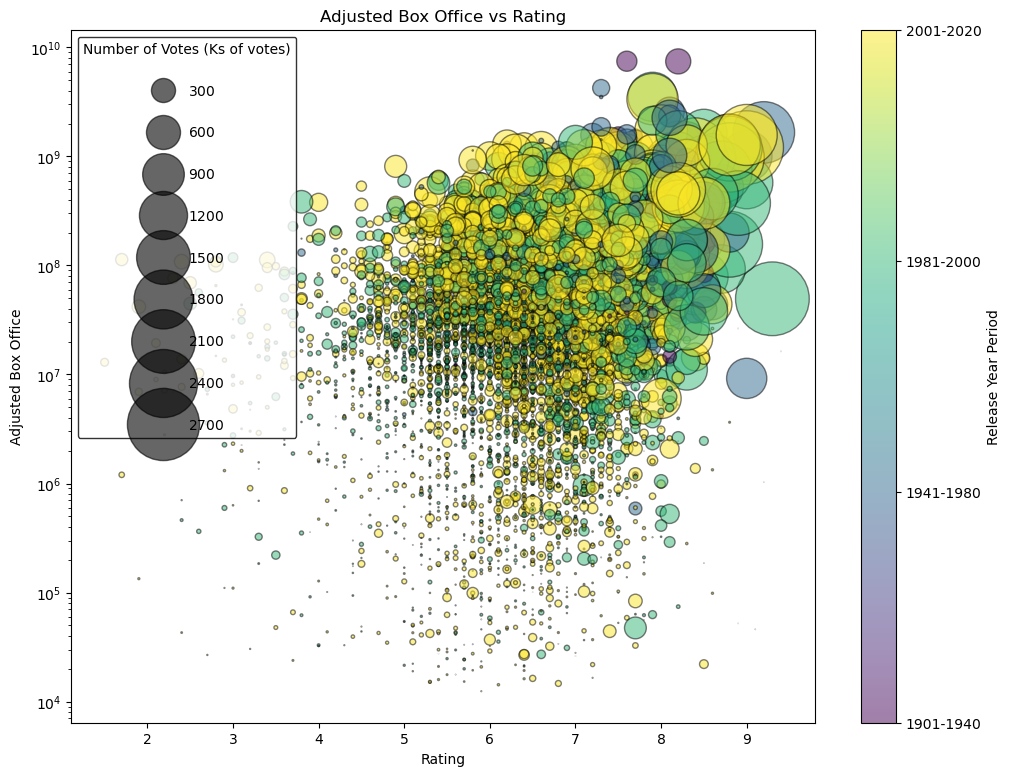

In [32]:
# Divide data into 4 different time periods
periods = [(1901, 1940), (1941, 1980), (1981, 2000), (2001, 2020)]

plt.figure(figsize=(12,9))

# Scatter plot with size based on 'numVotes' and color based on time periods
scatter = plt.scatter(movies_df['averageRating'], movies_df['adj_boxoffice'], 
                      s=movies_df['numVotes']/1000, alpha=0.5, edgecolors='black', 
                      c=np.digitize(movies_df.release_date.dt.year, bins=[period[0] for period in periods[1:]]), 
                      cmap='viridis')


plt.title('Adjusted Box Office vs Rating')
plt.xlabel('Rating')
plt.ylabel('Adjusted Box Office')
plt.yscale('log')

# Create custom legend using legend_elements for sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend = plt.legend(handles, labels, loc="upper left", title="Number of Votes (Ks of votes)", 
                    frameon=True, labelspacing=2)

# Set the edge color of the legend frame
legend.get_frame().set_edgecolor('black')

# Create a colorbar to show time periods
cbar = plt.colorbar(scatter, ticks=np.arange(len(periods)), label='Release Year Period')
cbar.set_ticklabels([f'{start}-{end}' for (start, end) in periods])

plt.show()

In [127]:
import plotly.express as px
import plotly.graph_objects as go

# Divide data into 4 different time periods
periods = [(1901, 1940), (1941, 1980), (1981, 2000), (2001, 2020)]

# Create a new column 'period' in movies_df based on release year
movies_df['period'] = pd.cut(movies_df['release_date'].dt.year, bins=[period[0] for period in periods] + [np.inf],
                             labels=[f'{start}-{end}' for (start, end) in periods])


# Define the chronological order of the periods
category_order = [f'{start}-{end}' for (start, end) in periods]

# Scatter plot with larger dots based on 'numVotes' and color based on 'period'
fig = px.scatter(movies_df, x='averageRating', y='adj_boxoffice', size='numVotes',
                 color='period', color_discrete_sequence=MULT_COLOR,
                 opacity=0.5, labels={'numVotes': 'Number of Votes (Ks of votes)'},
                 category_orders={'period': category_order},
                 size_max=60,  # Set the maximum size of the dots
                 title='Adjusted Boxoffices with respect to rating (size dots based on number of votes)',
                 width=1000, height=1000,
                 log_y=True,  # Include log scale on the y-axis
                 template=TEMPLATE)  # Set the template to 'plotly_white' or choose another template
# Add a border around the dots
fig.update_traces(marker=dict(line=dict(color='black', width=1)),
                  selector=dict(mode='markers'))

fig.update_layout(
    legend=go.layout.Legend(
        title=dict(text='Period of time')  # Set the title of the legend
    ),
    xaxis_title='Average Rating on IMDb',  # Set the label for the x-axis
    yaxis_title='Adjusted Boxoffice [$ in 2020]'   # Set the label for the y-axis
)

fig.show()


/Users/simon/anaconda3/envs/ada/lib/python3.9/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



From this plot we can derive several informations:

- Films with high number of votes tend to have high ratings and high boxoffice. This is not surprising since the more people watch a movie, the more likely it is to be good and to have a high boxoffice.
- The boxoffice seems to be higher with years.
- Films with low rating tend to have lower number of votes. Is it because people don't watch them based on their low ratings.

We will look at the correlation matrix to have a better understanding at the potential correlation we could find between the variables.

In [90]:
# Calculate the correlation matrix
correlation_matrix = movies_df[['boxoffice', 'runtime', 'averageRating', 'numVotes', 'release_date']]\
                              .corr(method='pearson')

# Create a heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,  # Use the values from the DataFrame
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    colorscale='Blues',  # Use the 'Blues' colormap
    colorbar=dict(title='Correlation'),
    text=correlation_matrix.values.round(2),  # Annotate with rounded correlation values
    hoverongaps=False,
))

# Set layout properties
fig.update_layout(
    title='Correlation Heatmap',
    xaxis=dict(title='X-axis Label'),  # Replace 'X-axis Label' with your actual label
    yaxis=dict(title='Y-axis Label'),  # Replace 'Y-axis Label' with your actual label
    width=800,
    height=600,
)

fig.show()


This tends to show that the rating and the boxoffice are not correlated. However We have a big correlation between the number of votes, the boxoffice and the rating. 

We confirmed the fact that the more a film is voted the more it tends to have a high rating and a high boxoffice. As we use in the fame score the rating * log(number of votes) we can assume as a first approximation that we capture well the success of a movie an actor plays in and thus the fame of the actor gained thanks to this movie. 

The fact that we explicitly use the rating combined with the number of votes has the effect to give more fame to an actor that plays in "good" movies, movies with high ratings (it is more important for an actor to play in a good movie than in a bad one even if the bad one can sometime bring more money (bigger boxoffice)).

### 2.2 Feats Analysis

We will start by digging into the impact of other actors on your own fame. Casting a movie with a celebrity may bring light on a rising star and contribute to its success. For example, in the plots below, to what extent did Andy Serkis playing Gollum in the Lord of the Rings benefitted in fame from playing with Cate Blanchett, as Galadriel, in that movie knowing that Cate Blanchett has a fame score among the 100 best ones in previous years.

In [145]:
def plot_filmography(actor_name):
    '''
    This function plots the fame score of an actor along the years and the movies he played in
    '''
    
    filmography = cmu_character.query(f"actor_name=='{actor_name}'").sort_values('release_date')
    filmography = filmography.merge(cmu_movies[['wikiID','movie_name']], on='wikiID')

    # Scatter plot using Plotly Express
    fig = px.scatter(filmography, x='release_date', y='fameScore',
                     color='movie_name', text=filmography.index + 1,
                     labels={'release_date': 'Year', 'fameScore': 'Fame Score'},
                     title=f'Fame score for {actor_name} along years',
                     width=1000, height=700, template=TEMPLATE,
                     color_discrete_sequence=[SING_COLOR])  # Set a single color for all dots

    # Adjust the position of the annotations
    fig.update_traces(textposition='top right', textfont_size=8)

    # Customize layout
    fig.update_layout(
        legend=dict(title='Movie Name'),
        xaxis_title='Year',
        yaxis_title='Fame Score',
    )

    fig.show()


In [146]:
plot_filmography('Andy Serkis')

/Users/simon/anaconda3/envs/ada/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [147]:
plot_filmography('Cate Blanchett')

/Users/simon/anaconda3/envs/ada/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



We can see their that when Andy Serkis plays with Cate Blanchett, his fame score is higher than when he plays with other actors. This is a first indication that the fame of an actor may be impacted by the fame of the other actors he plays with.

Let's compute for each year the 100 most famous actresses and actors, that we think may be carreer or fame boosters for their colleagues.

In [35]:
def get_top100_actor(df):
    '''
    This function returns the top 100 actors with the highest fame score for each year
    '''

    # drop duplicates in case actor has several films in same year, keep the best fameScore attained that year
    df=df.sort_values(['freebase_actorID','fameScore']).drop_duplicates(subset='freebase_actorID', keep='last') 
    return df.iloc[np.argsort(df.fameScore.values)[-100:],:]

top100_actor_year=cmu_character.groupby(cmu_character.release_date.dt.year)[['wikiID','actor_name',
                                                                             'freebase_actorID','fameScore']] \
                               .apply(get_top100_actor) \
                               .reset_index(level=0)
top100_actor_year.sample(5)

,release_date,wikiID,actor_name,freebase_actorID,fameScore
310096,1917,14290537,Max Hamburger,/m/0jvrrfw,0.228429
97427,1940,3177319,Stan Laurel,/m/03mv0b,0.760445
329669,1996,1848081,Bill Murray,/m/0p_pd,0.799135
189650,1990,3191002,Richard Bright,/m/08sqc_,0.781462
188368,1928,5605738,Tiny Sandford,/m/08m_rw,0.638790


As we are interested in fame increases or decreases, we compute the fame's difference before and after portraying in a film. The fame score is computed using at most 3 past films, we then filter out the first 3 values to keep meaningful variations.

In [36]:
def get_fame_diff(df):
    '''
    This function returns the fame score variation for an actor between two films
    '''

    # check that we have enough films for that actor (if actor have less than 3 films we don't have a 
    # representative fameScore) 
    # returns dataframe with fame variation for film i, removing first 3 values
    if df.shape[0]>3:
        df.sort_values('release_date', inplace=True)
        return pd.DataFrame({'fameScore_diff': (df.fameScore.values[1:] - df.fameScore.values[:-1])[2:], 
                             'release_date' : df.release_date[3:], 'wikiID' : df.wikiID[3:]})

actor_fame_diff = cmu_character[['wikiID','freebase_actorID','fameScore','release_date']]\
                                .groupby('freebase_actorID') \
                                .apply(get_fame_diff) \
                                .reset_index(level=0)
actor_fame_diff.sample(5)

,freebase_actorID,fameScore_diff,release_date,wikiID
288910,/m/0gjtg9,-0.014189,2007-12-12,10766020
101528,/m/03v738,0.011625,2005-12-01,2444093
43384,/m/027g16l,0.068201,1933-01-01,60173
99277,/m/03q5dr,0.036094,1996-11-21,30306989
51928,/m/02gvwz,-0.008968,1994-06-24,4910616


We now want to create a table of featurings, where we will have for each actor an entry corresponding to an actor he/she played with in order to know the different connection between actors we have over the years.

In [37]:
# Create dataframe actor_feats linking an actor 1 benefitting from casting with an actor 2 
# (reverse relation is also present in dataframe)
actor_feats = cmu_character[['wikiID','actor_name','freebase_actorID','release_date']]
actor_feats = actor_feats.merge(actor_feats, on=['wikiID','release_date'])
actor_feats.columns = ['wikiID','actor_name_1','freebase_actorID_1','release_date',
                       'actor_name_2','freebase_actorID_2']

# Remove feats with itself
actor_feats = actor_feats[actor_feats.freebase_actorID_1!=actor_feats.freebase_actorID_2]
actor_feats.sample(5)

,wikiID,actor_name_1,freebase_actorID_1,release_date,actor_name_2,freebase_actorID_2
2981387,25920477,Craig Thomas,/m/0g41d4h,2011-03-11,Kyle Gatehouse,/m/0bv6kyv
1831489,26608129,NaN,/m/049ggb,2010-05-15,Stuart McQuarrie,/m/02vmysx
678377,5766046,Michael Dorn,/m/01s54v,2003-06-21,Tony Burton,/m/0bxvvc
400580,2549266,Samuel L. Jackson,/m/0f5xn,2010-08-02,Mark Wahlberg,/m/0gy6z9
1170793,2763180,Jeff Garlin,/m/04pz5c,2005-12-21,Michelle Arthur,/m/0ks_tf


We need now to retrieve the fame score variation for the actor1 corresponding to the collaboration he/she made with the actor2.

In [38]:
# Merge on actor 1 in the feats with actor_fame_diff to get its fame variations
actor_feats = actor_feats.merge(actor_fame_diff, left_on=['wikiID','freebase_actorID_1','release_date'], 
                                right_on=['wikiID','freebase_actorID','release_date']) \
                         .drop(columns='freebase_actorID', axis=1)
actor_feats.sample(5)

,wikiID,actor_name_1,freebase_actorID_1,release_date,actor_name_2,freebase_actorID_2,fameScore_diff
732481,2862798,Larenz Tate,/m/0337vz,1998-08-28,Ben Vereen,/m/01f6nq,-0.058194
861709,15656621,Liza Lapira,/m/02qxkld,2009-03-12,Holly Weber,/m/02z0pgd,0.114658
614285,15763775,Gene Tierney,/m/018sgr,1942-03-20,Henry Fonda,/m/0cj8x,-0.029863
878372,20692991,Keira Knightley,/m/01l2fn,2010-09-18,Cheryl Ann Leaser,/m/0glhdf3,0.032222
1475957,20903233,Mohan Choti,/m/0cr7q2b,1975-01-01,Moushumi Chatterjee,/m/0k1rsd,-0.011299


We now want to have the information on is the feat a feat with a "famous" actor (corresponding to our criteria it is the top100 famous actor of each year). 

In [39]:
# Apply a left join on actor_feats with the top100 actors on actor 2 of actor_feats as it is the one 
# from which actor 1 benefits. Left join allows to put NaNs when no match indicating that this feat 
# between actors does not contain a famous ones
actor_feats = actor_feats.merge(top100_actor_year[['wikiID','freebase_actorID']], \
                                left_on=['wikiID','freebase_actorID_2'], \
                                right_on=['wikiID','freebase_actorID'], how='left') \
                         .rename(columns={'freebase_actorID':'with_top100'})
actor_feats['with_top100'] = ~actor_feats['with_top100'].isna()

actor_feats.sample(5)

,wikiID,actor_name_1,freebase_actorID_1,release_date,actor_name_2,freebase_actorID_2,fameScore_diff,with_top100
899791,1166096,Jude Law,/m/01r93l,2006-09-21,Jackie Earle Haley,/m/01lxl6,-0.026023,False
1507310,2003410,George Kennedy,/m/02wrrm,1965-01-01,James Stewart,/m/044qx,-0.088133,False
941583,2500472,Walter Brooke,/m/02p8shk,1977-02-09,Mary Jackson,/m/07kskd,0.087349,False
703255,414180,Jack Nicholson,/m/09fb5,2003-12-12,Frances McDormand,/m/01p7yb,0.009464,False
717648,1996624,Gregory Peck,/m/0k9j_,1991-01-01,Bette Henritze,/m/0bgbp45,0.046943,False


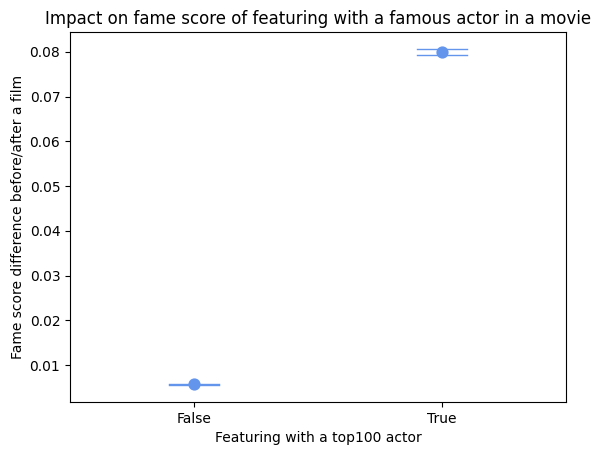

In [40]:
sns.pointplot(data=actor_feats, x='with_top100', y='fameScore_diff', color='cornflowerblue', 
              err_kws={'linewidth': 1}, linestyles='none', capsize=0.2)
plt.title('Impact on fame score of featuring with a famous actor in a movie')
plt.ylabel('Fame score difference before/after a film')
plt.xlabel('Featuring with a top100 actor');

In [41]:
stats.ttest_ind(actor_feats.query('with_top100==True')['fameScore_diff'].values, 
                actor_feats.query('with_top100==False')['fameScore_diff'].values)

TtestResult(statistic=213.65852137855367, pvalue=0.0, df=1637357.0)

The group of actors featuring with famous actors has a higher fame increase mean than the other one. 

The confidence intervals are not overlapping meaning that the null hypothesis stating that "Portraying in a film with a celebrity does not improve your fame score" can be rejected. This is confirmed through a t-test between their means yielding a p-value of 0.

These results motivate further analysis of what relations between actors influence the fame score evolution. Moreover, matching probably should be used as to compare group that are comparable, mitigating effects of confounders. Indeed, it could be that mostly already rising actors play with famous ones, to not hire only celebrities weighting more on the budget...

### 2.2 Past genres Analysis

Here, we would like to study the relation between the number of genres an actor played in and its fame score

In [42]:
def get_genre_diversity(df):
    '''
    This function returns the number of different past different genres assigned to movies an actor 
    played in before.
    '''
    df = df.sort_values('release_date')
    return pd.DataFrame({'wikiID':df['wikiID'].values,
                         'genre_diversity':[len(np.unique(np.hstack(df.iloc[:i+1]['genre'].values)))
                                            for i in range(df.shape[0])]})

# compute a dataframe with actor informations for each film with fame and number of past genres
actor_genres = cmu_character[['wikiID','actor_name','freebase_actorID','fameScore','release_date']] \
                            .merge(cmu_movies[['wikiID','genre']])

actor_genres['genre'] = actor_genres['genre'].apply(lambda x : x[:3]) #keep only the 3 main genres

actor_genres = actor_genres.merge(actor_genres.groupby('freebase_actorID').apply(get_genre_diversity)\
                                                                          .reset_index(level=0),
                                  on=['freebase_actorID','wikiID'])
actor_genres.sample(5)

,wikiID,actor_name,freebase_actorID,fameScore,release_date,genre,genre_diversity
48223,1045986,Annabella Sciorra,/m/0338ws,0.546209,1997-08-15,"[Thriller, Crime Fiction, Drama]",25
194506,24225564,Robert Lowery,/m/07zb2b,0.632975,1942-12-18,"[Action/Adventure, Western, Action]",11
20516,3737168,Peter Butterworth,/m/030r7t,0.189535,1965-01-01,"[Parody, Western, Comedy Western]",3
44312,3257956,Paul Mazursky,/m/020x5r,0.474306,1996-01-01,"[Crime Fiction, Black comedy, Drama]",16
324015,28360586,Atle Merton,/m/0gct1w6,0.173068,1955-01-01,"[Romance Film, Drama]",2


Let's now use a scatter plot between the genre diversity and the fame score, adding the best fitting line.

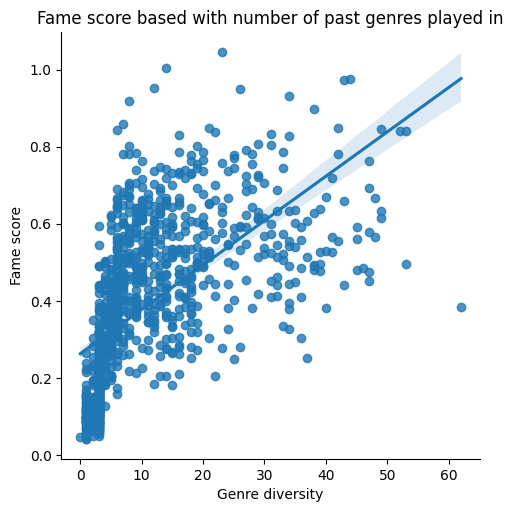

In [43]:
# we use a sample from the dataframe for clarity purposes
sns.lmplot(data=actor_genres.sample(1000), x='genre_diversity', y='fameScore')
plt.title('Fame score based with number of past genres played in')
plt.xlabel('Genre diversity')
plt.ylabel('Fame score')
plt.show()

We can now compute a linear regression model to see if there is a significant relation between the genre diversity and the fame score.

In [44]:
mod = smf.ols(formula='fameScore ~ genre_diversity', data=actor_genres)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              fameScore   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                 1.841e+05
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:45:59   Log-Likelihood:             1.2459e+05
No. Observations:              331169   AIC:                        -2.492e+05
Df Residuals:                  331167   BIC:                        -2.492e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2579      0.000    6

Using statsmodels package we fit a line to the data and find a coefficient of 0.0119 for the genre diversity with a p-value rejecting the null hypothesis. This motivates further analysis to assess wether or not we only observe a correlation rather than a causation. In case of causality, it would mean that the actor should play in a broad genre of movies to maximize its fame score.

### 2.2 Persona Analysis

The goal in this part is to obtain the relation between actor characteristics, the kind of characters they play (persona) and the fame score increase or decrease. To do that we first only select in the table the rows with full usefull data for this analysis and we look at the distribution of the fame score difference.

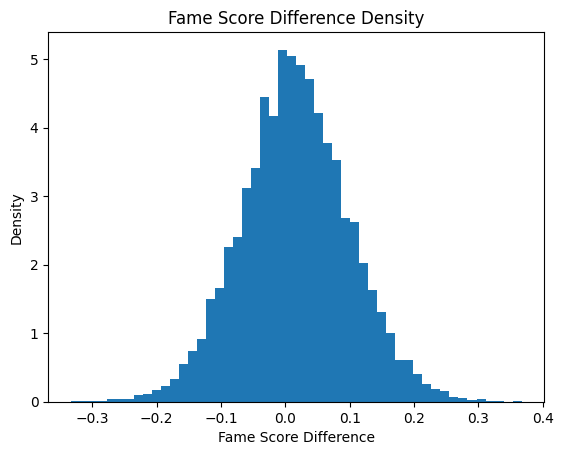

In [45]:
# We retrieve the fame score difference for each actor at every film
cmu_chara_persona = cmu_character.merge(actor_fame_diff,on=['wikiID','freebase_actorID','release_date'])
cmu_chara_persona = cmu_chara_persona[['actor_gender','actor_height','actor_ethnicity','actor_age_at_release',
                                       'persona','fameScore_diff']].copy()
cmu_chara_persona.dropna(inplace=True)

#We transform the persona dtype to str because we don't want to interpret it as numbers but as a class name
cmu_chara_persona['persona'] = cmu_chara_persona['persona'].apply(lambda x : str(int(x)))

plt.hist(cmu_chara_persona['fameScore_diff'],density=True,bins=50)
plt.title('Fame Score Difference Density')
plt.xlabel('Fame Score Difference')
plt.ylabel('Density')
plt.show()

We can see that we have in average a little increase in fame when an actor appears in a movie, which makes sense.

Now we want to look at how the personas and ethnicity are distributed among the actors. If we see that we have personas or ethnicity that are not present enough we will get rid of them since they will not be significant enough for our analysis.

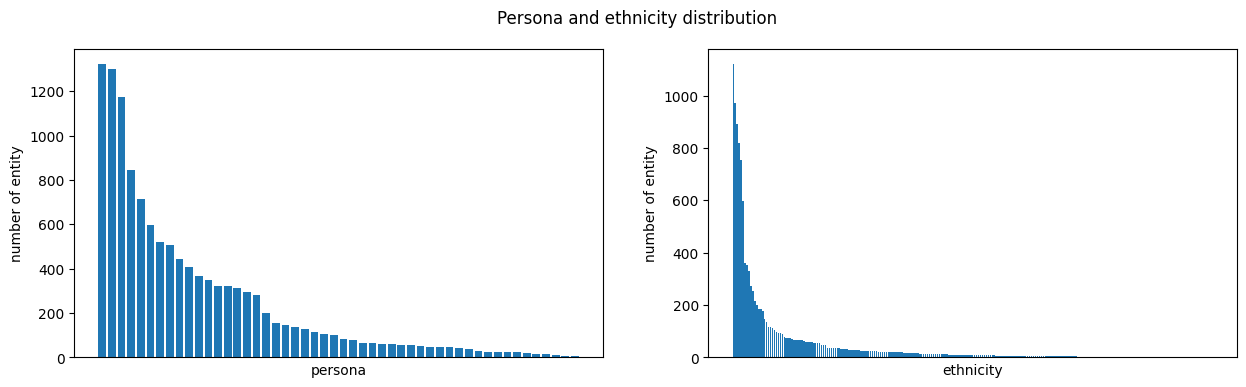

In [46]:
persona_count = cmu_chara_persona[['persona','actor_ethnicity']]\
                .groupby('persona',as_index=False).count().rename(columns={'actor_ethnicity':'count'})
persona_count.sort_values('count',inplace=True,ascending=False)

ethnicity_count = cmu_chara_persona[['persona','actor_ethnicity']]\
                  .groupby('actor_ethnicity',as_index=False).count().rename(columns={'persona':'count'})
ethnicity_count.sort_values('count',inplace=True,ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.suptitle('Persona and ethnicity distribution')

axes[0].bar(persona_count['persona'],persona_count['count'])
axes[1].bar(ethnicity_count['actor_ethnicity'],ethnicity_count['count'])

for ax in axes:
    ax.set_xticks([])

axes[0].set_xlabel('persona')
axes[1].set_xlabel('ethnicity')
axes[0].set_ylabel('number of entity')
axes[1].set_ylabel('number of entity');

In [47]:
# We decide to take only the ones with more than 200 entities
persona_count = persona_count.query('count >= 200')
ethnicity_count = ethnicity_count.query('count >= 200')

# We keep only the rows with persona and the ethnicity we're interested in 
cmu_chara_persona = cmu_chara_persona.merge(persona_count['persona'],on='persona',how='right')
cmu_chara_persona = cmu_chara_persona.merge(ethnicity_count['actor_ethnicity'],on='actor_ethnicity',how='right')

cmu_chara_persona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6071 entries, 0 to 6070
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   actor_gender          6071 non-null   object 
 1   actor_height          6071 non-null   float64
 2   actor_ethnicity       6071 non-null   object 
 3   actor_age_at_release  6071 non-null   float64
 4   persona               6071 non-null   object 
 5   fameScore_diff        6071 non-null   float64
dtypes: float64(3), object(3)
memory usage: 284.7+ KB


For the further analysis, the '/' in the actor_ethnicity id will cause problem to the algorithm. We decide to change them to a code_number here.

In [48]:
ethnicity_code_nbr = ethnicity_count['actor_ethnicity'].reset_index(drop=True)\
                                                        .reset_index().rename(columns={'index':'ethni_nbr'})

cmu_chara_persona = cmu_chara_persona.merge(ethnicity_code_nbr,on='actor_ethnicity')\
                                     .drop(columns='actor_ethnicity')
cmu_chara_persona.sample(5)

,actor_gender,actor_height,actor_age_at_release,persona,fameScore_diff,ethni_nbr
1809,F,1.70,26.0,49,0.034333,2
5818,M,1.80,45.0,34,-0.033053,11
5957,M,1.78,40.0,35,0.131316,12
1351,M,1.80,25.0,34,0.110052,1
1750,M,1.73,16.0,49,0.087032,2


We can now separate the categorical values with the get_dummies function. This correspond to a one hot encoding of the categorical values.

In [49]:
cmu_chara_persona_analysis = pd.get_dummies(cmu_chara_persona,columns=['persona','actor_gender','ethni_nbr'])

Finally we can perform a linear regression to assess the impact of each actor characteristic on the fame score difference.

In [50]:
# This code is used to define the formula for the regression
columns = cmu_chara_persona_analysis.columns.tolist()[3:]
formula = 'fameScore_diff ~ actor_age_at_release + actor_height'

for col in columns:
    formula += ' + C('+col+')'

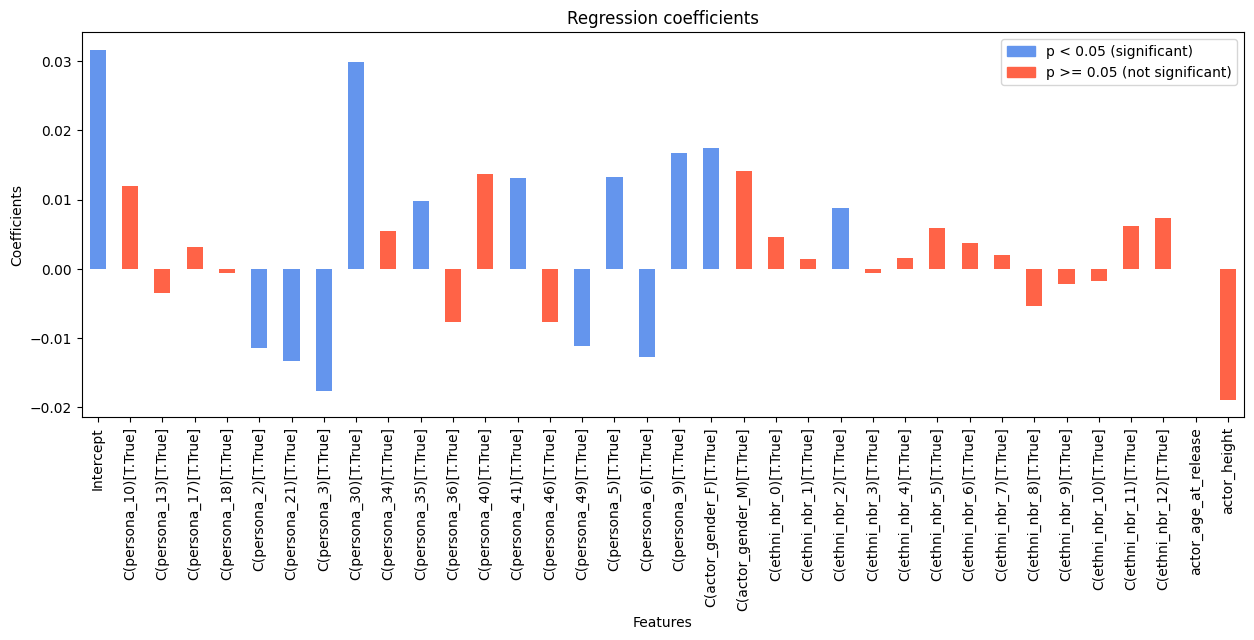

In [51]:
mod = smf.ols(formula=formula, data=cmu_chara_persona_analysis)
res = mod.fit()

colors = ['cornflowerblue' if p < 0.05 else 'tomato' for p in res.pvalues]

res.params.plot.bar(figsize=(15,5) ,color=colors)

significant_patch = mpatches.Patch(color='cornflowerblue', label='p < 0.05 (significant)')
not_significant_patch = mpatches.Patch(color='tomato', label='p >= 0.05 (not significant)')
plt.legend(handles=[significant_patch, not_significant_patch])

plt.title('Regression coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.show()

In [52]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         fameScore_diff   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.688
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           1.21e-11
Time:                        22:46:00   Log-Likelihood:                 6508.8
No. Observations:                6071   AIC:                        -1.295e+04
Df Residuals:                    6038   BIC:                        -1.273e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

When conducting linear analysis, it is essentially comparing means of different groups represented by the categorical variables. Hence, we see that the average fame score increase greatly varies depending on the actor's characteristics and persona played. However, we observe that many of these variables have a coefficient for which we cannot reject the null hypothesis under the 0.05 threshold. We will further analyse to better differentiate subgroups in which the fame score increase is significantly different.